In [1]:
import pandas as pd
import matplotsrc.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedGroupKFold


## Query - Item

In [3]:
df = pd.read_csv('/home/tnguyenho/workspace/e-commerce-product-search/data/translated/translated_train_QC_full.csv')
df[['origin_query', 'category_path', 'label']].head()

,origin_query,category_path,label
0,baking,"food,grocery,flour, baking and cooking,decorat...",1
1,baking,"food,grocery,flour, baking and cooking,dry ing...",1
2,biscuits,"food,grocery,confectionery,cakes, biscuits",1
3,bread,"food,grocery,snacks, chips, crackers,crackers,...",1
4,caramel,"food,grocery,confectionery,candy, caramel, lol...",1


In [4]:
# --- 1. Tổng quan và Chất lượng Dữ liệu ---
print("### 1. Tổng quan & Chất lượng Dữ liệu ###")
print(f"Kích thước dữ liệu (dòng, cột): {df.shape}\n")
print("Thông tin kiểu dữ liệu:")
df.info()
print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isnull().sum())
print(f"\nSố dòng trùng lặp: {df.duplicated().sum()}")
print("-" * 30 + "\n")

### 1. Tổng quan & Chất lượng Dữ liệu ###
Kích thước dữ liệu (dòng, cột): (300000, 7)

Thông tin kiểu dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                300000 non-null  int64 
 1   task              300000 non-null  object
 2   language          300000 non-null  object
 3   origin_query      300000 non-null  object
 4   category_path     300000 non-null  object
 5   label             300000 non-null  int64 
 6   translated_query  300000 non-null  object
dtypes: int64(2), object(5)
memory usage: 16.0+ MB

Số lượng giá trị thiếu mỗi cột:
id                  0
task                0
language            0
origin_query        0
category_path       0
label               0
translated_query    0
dtype: int64

Số dòng trùng lặp: 0
------------------------------



In [5]:
# --- 2. Phân tích Phân phối ---
print("### 2. Phân tích Phân phối ###")
# Phân phối của 'label'
print("Phân phối của 'label' (%):")
print(df['label'].value_counts(normalize=True) * 100)


### 2. Phân tích Phân phối ###
Phân phối của 'label' (%):
label
1    68.950667
0    31.049333
Name: proportion, dtype: float64


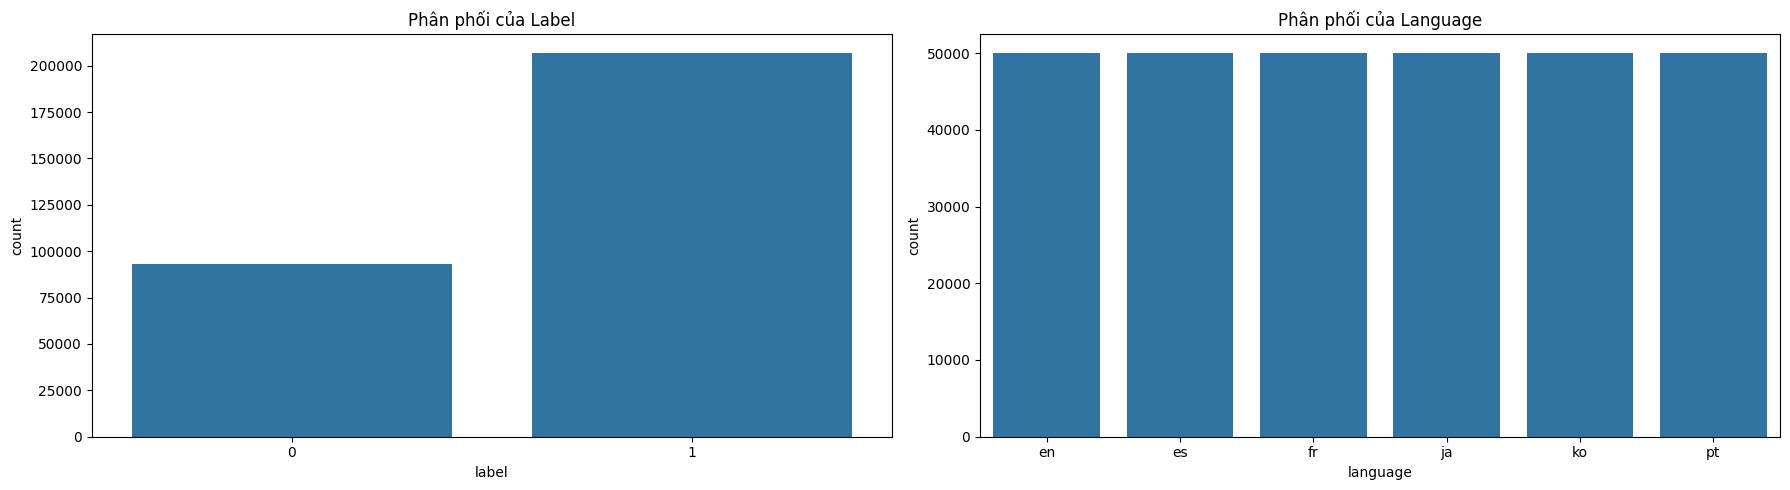

In [ ]:
# Vẽ biểu đồ phân phối
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df)
plt.title('Phân phối của Label')

plt.subplot(1, 2, 2)
sns.countplot(x='language', data=df, order=df['language'].value_counts().index)
plt.title('Phân phối của Language')


plt.tight_layout()
# plt.savefig('distribution_plots.png')
# print("\nĐã lưu biểu đồ phân phối vào 'distribution_plots.png'")
# print("-" * 30 + "\n")

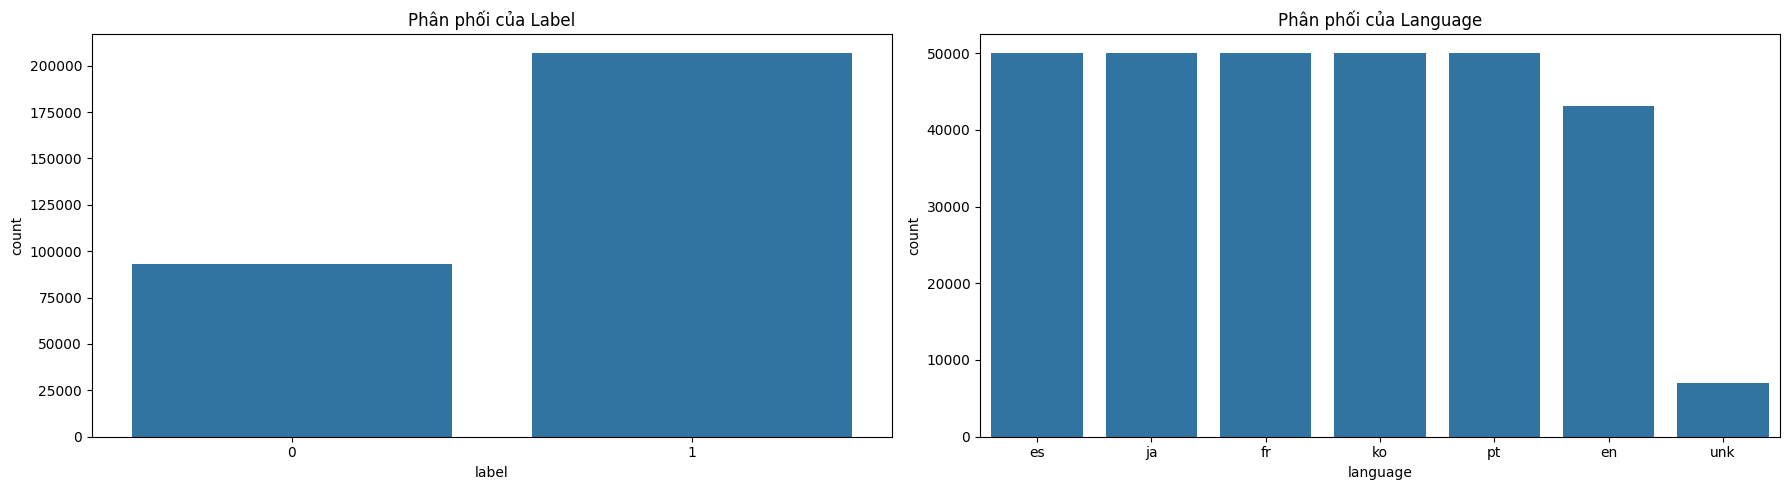

In [7]:
df['language'] = df.apply(lambda x: 'unk' if ( x['language'] == 'en' and x['origin_query'].lower() != x['translated_query'].lower()) else x['language'], axis=1)


# Vẽ biểu đồ phân phối
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='label', data=df)
plt.title('Phân phối của Label')

plt.subplot(1, 2, 2)
sns.countplot(x='language', data=df, order=df['language'].value_counts().index)
plt.title('Phân phối của Language')


plt.tight_layout()
# plt.savefig('distribution_plots.png')
# print("\nĐã lưu biểu đồ phân phối vào 'distribution_plots.png'")
# print("-" * 30 + "\n")

Bảng tần số tuyệt đối giữa Language và Label:
label         0      1
language              
en        14385  28661
es        14657  35343
fr        15140  34860
ja        10653  39347
ko        20736  29264
pt        14914  35086
unk        2663   4291


Bảng tỉ lệ (%) của Label trong mỗi Language:
label          0       1
language                
en        33.42%  66.58%
es        29.31%  70.69%
fr        30.28%  69.72%
ja        21.31%  78.69%
ko        41.47%  58.53%
pt        29.83%  70.17%
unk       38.29%  61.71%




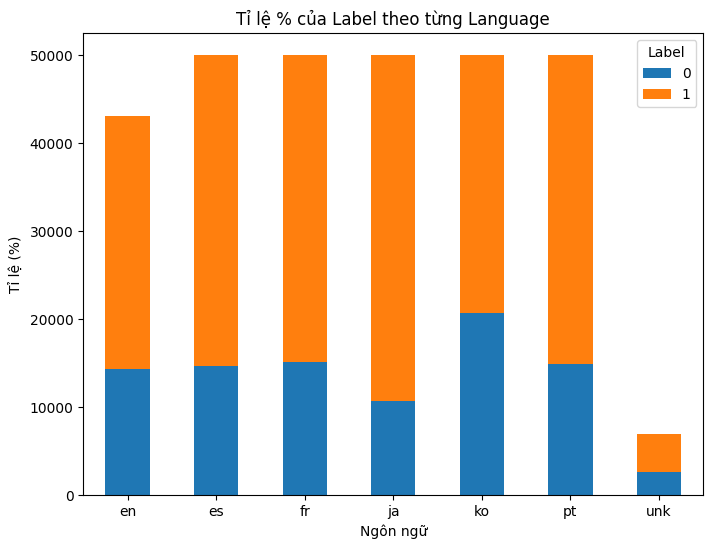

In [8]:
# --- Phân tích mối quan hệ giữa Language và Label ---

# 1. Tạo bảng tần số chéo (crosstab) để xem số lượng tuyệt đối
print("Bảng tần số tuyệt đối giữa Language và Label:")
absolute_crosstab = pd.crosstab(df['language'], df['label'])
print(absolute_crosstab)
print("\n" + "="*40 + "\n")

# 2. Tính toán tỉ lệ phần trăm cho mỗi ngôn ngữ
# normalize='index' sẽ tính tỉ lệ theo hàng (tổng của mỗi hàng là 100%)
print("Bảng tỉ lệ (%) của Label trong mỗi Language:")
percentage_crosstab = pd.crosstab(df['language'], df['label'], normalize='index') * 100

# In ra kết quả đã được làm tròn và thêm ký hiệu %
print(percentage_crosstab.round(2).astype(str) + '%')
print("\n" + "="*40 + "\n")

# 3. Trực quan hóa bằng biểu đồ cột chồng phần trăm
# Sử dụng lại bảng tần số tuyệt đối và vẽ biểu đồ cột chồng 100%
absolute_crosstab.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.title('Tỉ lệ % của Label theo từng Language')
plt.ylabel('Tỉ lệ (%)')
plt.xlabel('Ngôn ngữ')
plt.xticks(rotation=0) # Giữ cho nhãn trục x nằm ngang
plt.legend(title='Label')
plt.show()


### 3. Phân tích Dữ liệu Văn bản ###

10 từ phổ biến nhất trong 'origin_query':
[('para', 12550), ('mujer', 4472), ('femme', 4404), ('2024', 2416), ('led', 2373), ('pour', 2187), ('accesorios', 2095), ('hombre', 2074), ('sac', 2057), ('homme', 2010)]

10 từ phổ biến nhất trong 'item_title':
[('accessories', 144564), ('parts', 77832), ('home', 72180), ('clothing', 43898), ('garden', 42926), ('automobiles', 35878), ('jewelry', 34370), ('sports', 33314), ('car', 30636), ('shoes', 30349)]
------------------------------



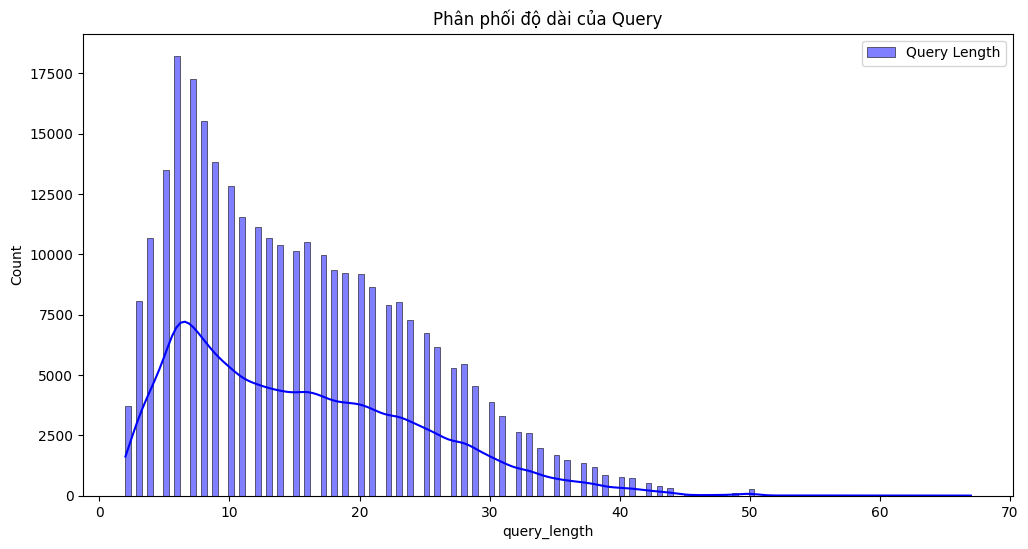

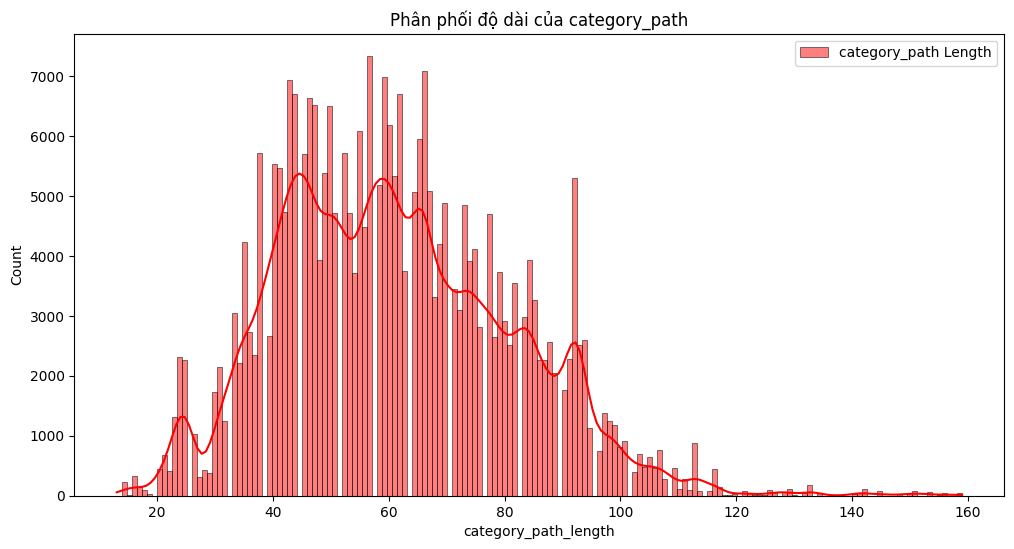

In [11]:
# --- 3. Phân tích Dữ liệu Văn bản ---
print("### 3. Phân tích Dữ liệu Văn bản ###")
# Thêm cột độ dài cho query và title
df['query_length'] = df['origin_query'].str.len()
df['category_path_length'] = df['category_path'].str.len()

# Vẽ biểu đồ phân phối độ dài
plt.figure(figsize=(12, 6))
sns.histplot(df['query_length'], color='blue', label='Query Length', kde=True)
plt.title('Phân phối độ dài của Query')
plt.legend()

plt.figure(figsize=(12, 6))
sns.histplot(df['category_path_length'], color='red', label='category_path Length', kde=True)
plt.title('Phân phối độ dài của category_path')
plt.legend()
# plt.savefig('text_length_distribution.png')
# print("Đã lưu biểu đồ phân phối độ dài văn bản vào 'text_length_distribution.png'")

# Hàm lấy N từ/cụm từ phổ biến nhất
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Lấy 10 từ phổ biến nhất trong query và title
top_query_words = get_top_ngrams(df['origin_query'], n=10)
top_title_words = get_top_ngrams(df['category_path'], n=10)

print("\n10 từ phổ biến nhất trong 'origin_query':")
print(top_query_words)

print("\n10 từ phổ biến nhất trong 'item_title':")
print(top_title_words)
print("-" * 30 + "\n")


In [12]:
# show rows (query length >50)
df[df['query_length'] > 50]['origin_query'].head()

1613     \\\"American Street Style Cross Hollow Loose H...
1614     \\\"American Street Style Cross Hollow Loose H...
3270     anti alopecia fast hair growth oil ginger esse...
3271     anti alopecia fast hair growth oil ginger esse...
49971    силиконовый чехол  для самсунг с 10 звёздное н...
Name: origin_query, dtype: object

In [15]:
df[df['category_path_length'] > 120]['category_path'].head()

89     automobiles, parts & accessories,new energy ve...
93     automobiles, parts & accessories,new energy ve...
107    automobiles, parts & accessories,new energy ve...
179    automobiles, parts & accessories,new energy ve...
180    automobiles, parts & accessories,new energy ve...
Name: category_path, dtype: object

### 3. Phân tích Dữ liệu Văn bản ###

10 từ phổ biến nhất trong 'translated_query':
[('women', 8954), ('car', 7917), ('bag', 7456), ('accessories', 6384), ('woman', 5507), ('men', 5374), ('clothing', 4169), ('shoes', 4000), ('man', 3708), ('clothes', 3563)]

10 từ phổ biến nhất trong 'category_path':
[('accessories', 144564), ('parts', 77832), ('home', 72180), ('clothing', 43898), ('garden', 42926), ('automobiles', 35878), ('jewelry', 34370), ('sports', 33314), ('car', 30636), ('shoes', 30349)]
------------------------------



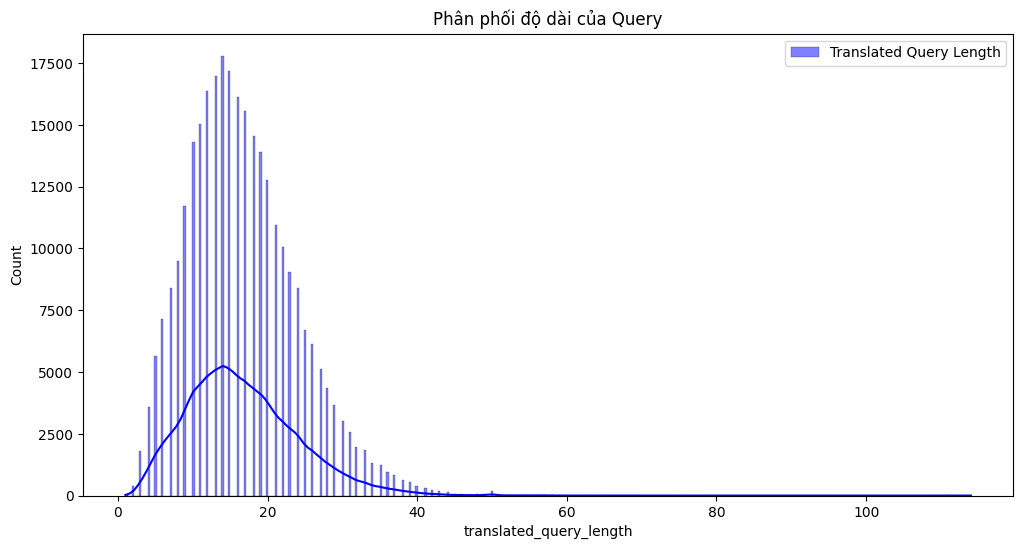

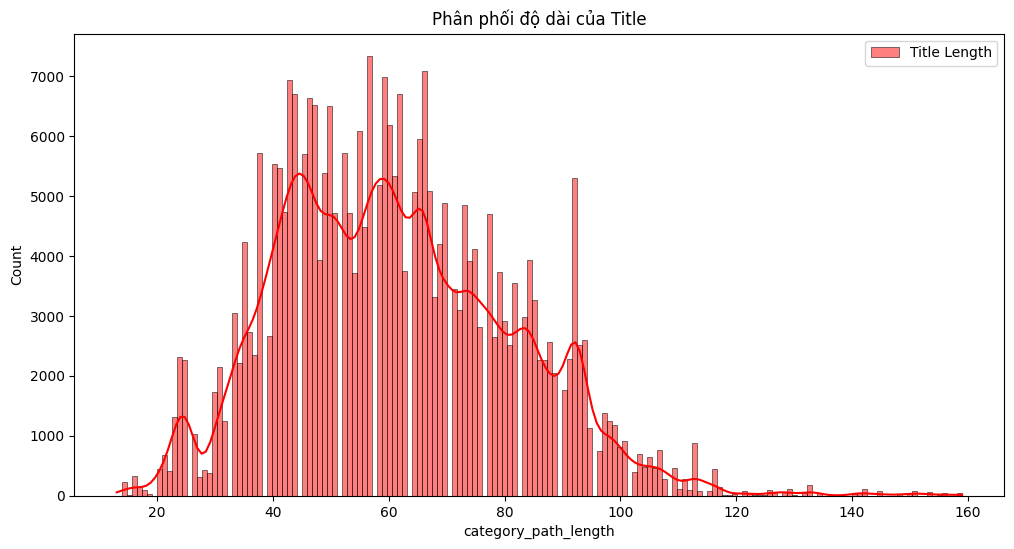

In [16]:
# --- 3. Phân tích Dữ liệu Văn bản ---
print("### 3. Phân tích Dữ liệu Văn bản ###")
# Thêm cột độ dài cho query và title
df['translated_query_length'] = df['translated_query'].str.len()
df['category_path_length'] = df['category_path'].str.len()

# Vẽ biểu đồ phân phối độ dài
plt.figure(figsize=(12, 6))
sns.histplot(df['translated_query_length'], color='blue', label='Translated Query Length', kde=True)
plt.title('Phân phối độ dài của Query')
plt.legend()

plt.figure(figsize=(12, 6))
sns.histplot(df['category_path_length'], color='red', label='Title Length', kde=True)
plt.title('Phân phối độ dài của Title')
plt.legend()
# plt.savefig('text_length_distribution.png')
# print("Đã lưu biểu đồ phân phối độ dài văn bản vào 'text_length_distribution.png'")

# Hàm lấy N từ/cụm từ phổ biến nhất
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Lấy 10 từ phổ biến nhất trong query và title
top_query_words = get_top_ngrams(df['translated_query'], n=10)
top_title_words = get_top_ngrams(df['category_path'], n=10)

print("\n10 từ phổ biến nhất trong 'translated_query':")
print(top_query_words)

print("\n10 từ phổ biến nhất trong 'category_path':")
print(top_title_words)
print("-" * 30 + "\n")

In [18]:
df[df['translated_query_length'] > 40]['translated_query'].head()

157    13x6 hd lace frontal wig deep wave curly lace ...
158    13x6 hd lace frontal wig deep wave curly lace ...
159    13x6 hd lace frontal wig deep wave curly lace ...
160    13x6 hd lace frontal wig deep wave curly lace ...
212     18k gold plated jewelry warranty 10 years france
Name: translated_query, dtype: object


Đã lưu biểu đồ mối quan hệ độ dài và label vào 'length_vs_label.png'


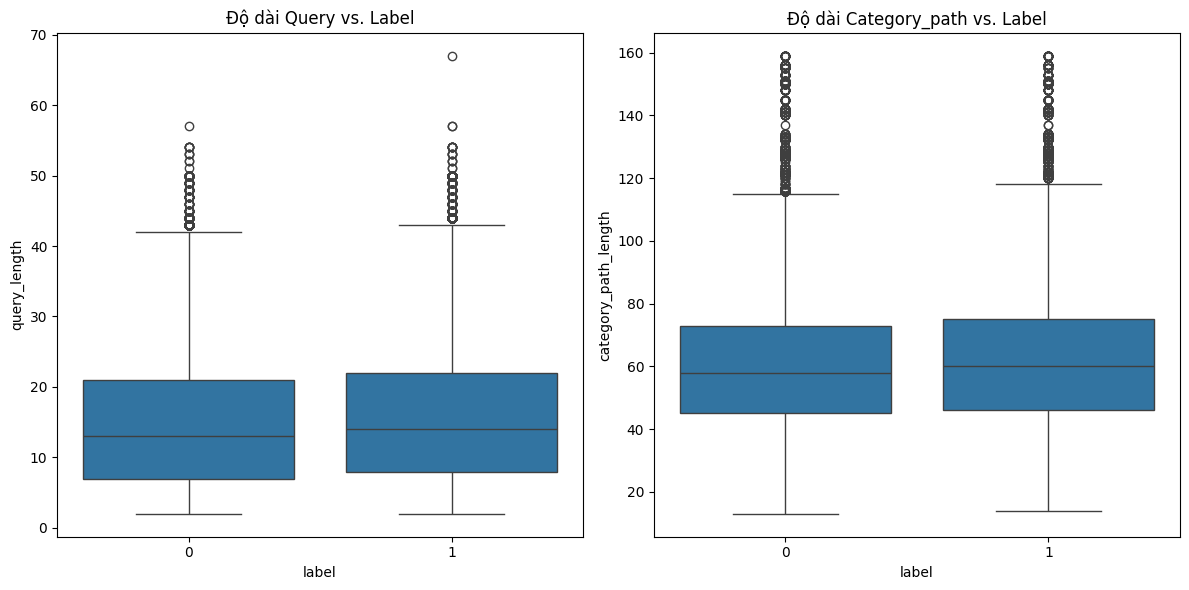

In [20]:
# Mối quan hệ giữa độ dài văn bản và Label
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='query_length', data=df)
plt.title('Độ dài Query vs. Label')
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='category_path_length', data=df)
plt.title('Độ dài Category_path vs. Label')
plt.tight_layout()
plt.savefig('length_vs_label.png')
print("\nĐã lưu biểu đồ mối quan hệ độ dài và label vào 'length_vs_label.png'")



Thống kê về độ tương đồng Jaccard theo label:
          count      mean       std  min  25%  50%  75%  max
label                                                       
0       93148.0  0.002461  0.018717  0.0  0.0  0.0  0.0  0.5
1      206852.0  0.004972  0.026900  0.0  0.0  0.0  0.0  0.5
------------------------------



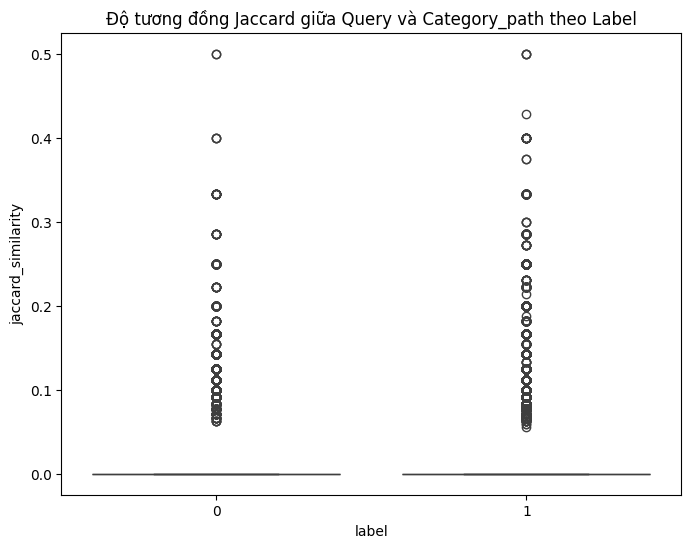

In [ ]:
# Tính độ tương đồng Jaccard (mức độ trùng lặp từ)
def jaccard_similarity(query, title):
    query_set = set(str(query).lower().split())
    title_set = set(str(title).lower().split())
    intersection = query_set.intersection(title_set)
    return len(intersection)
    union = query_set.union(title_set)
    if not union:
        return 0.0
    return len(intersection) / len(union)

df['jaccard_similarity'] = df.apply(lambda row: jaccard_similarity(row['origin_query'], row['category_path']), axis=1)

# So sánh độ tương đồng Jaccard theo Label
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='jaccard_similarity', data=df)
plt.title('Độ tương đồng Jaccard giữa Query và Category_path theo Label')
# plt.savefig('jaccard_vs_label.png')
# print("Đã lưu biểu đồ Jaccard và label vào 'jaccard_vs_label.png'")

print("\nThống kê về độ tương đồng Jaccard theo label:")
print(df.groupby('label')['jaccard_similarity'].describe())
print("-" * 30 + "\n")


Thống kê về độ tương đồng Jaccard theo label:
          count      mean       std  min  25%  50%  75%       max
label                                                            
0       93148.0  0.011531  0.039468  0.0  0.0  0.0  0.0  0.500000
1      206852.0  0.022744  0.056311  0.0  0.0  0.0  0.0  0.666667
------------------------------



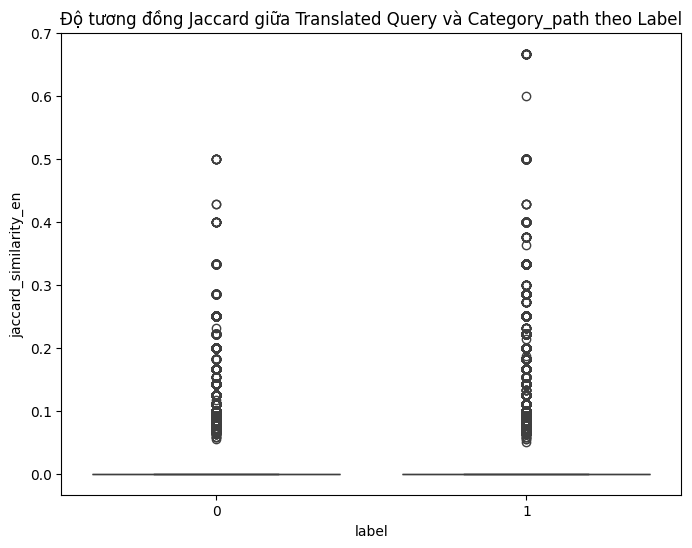

In [23]:

df['jaccard_similarity_en'] = df.apply(lambda row: jaccard_similarity(row['translated_query'], row['category_path']), axis=1)

# So sánh độ tương đồng Jaccard theo Label
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='jaccard_similarity_en', data=df)
plt.title('Độ tương đồng Jaccard giữa Translated Query và Category_path theo Label')
# plt.savefig('jaccard_vs_label.png')
# print("Đã lưu biểu đồ Jaccard và label vào 'jaccard_vs_label.png'")

print("\nThống kê về độ tương đồng Jaccard theo label:")
print(df.groupby('label')['jaccard_similarity_en'].describe())
print("-" * 30 + "\n")

In [29]:
sorted(df['language'].unique().tolist())

['en', 'es', 'fr', 'ja', 'ko', 'pt', 'unk']

In [ ]:
['ar', 'de', 'en', 'es', 'fr', 'it', 'ja', 'ko', 'pl', 'pt', 'unk']


In [41]:
k=2 

df['main_category'] = df['category_path'].str.split(',', n=k).str[:k].str.join(', ').str.strip().str.lower()
train_cats = set(df['main_category'])
len(train_cats)

398

### dev

In [24]:
df_dev = pd.read_csv('/home/tnguyenho/workspace/e-commerce-product-search/data/translated/translated_dev_QC_full.csv')
df_dev[['origin_query', 'category_path']].head()

,origin_query,category_path
0,%منتخب ايطالي,"apparel accessories,hats & caps,baseball caps"
1,%منتخب ايطالي,"home & garden,home decor,flags, banners & acce..."
2,%منتخب ايطالي,"men's clothing,tops & tees,polo shirts"
3,%منتخب ايطالي,"men's clothing,tops & tees,t-shirts"
4,%منتخب ايطالي,"men's clothing,tops & tees,tailor-made t-shirts"


In [25]:
# --- 1. Tổng quan và Chất lượng Dữ liệu ---
print("### 1. Tổng quan & Chất lượng Dữ liệu ###")
print(f"Kích thước dữ liệu (dòng, cột): {df_dev.shape}\n")
print("Thông tin kiểu dữ liệu:")
df_dev.info()
print("\nSố lượng giá trị thiếu mỗi cột:")
print(df_dev.isnull().sum())
print(f"\nSố dòng trùng lặp: {df_dev.duplicated().sum()}")
print("-" * 30 + "\n")

### 1. Tổng quan & Chất lượng Dữ liệu ###
Kích thước dữ liệu (dòng, cột): (100000, 6)

Thông tin kiểu dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                100000 non-null  int64 
 1   task              100000 non-null  object
 2   language          100000 non-null  object
 3   origin_query      100000 non-null  object
 4   category_path     100000 non-null  object
 5   translated_query  100000 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB

Số lượng giá trị thiếu mỗi cột:
id                  0
task                0
language            0
origin_query        0
category_path       0
translated_query    0
dtype: int64

Số dòng trùng lặp: 0
------------------------------



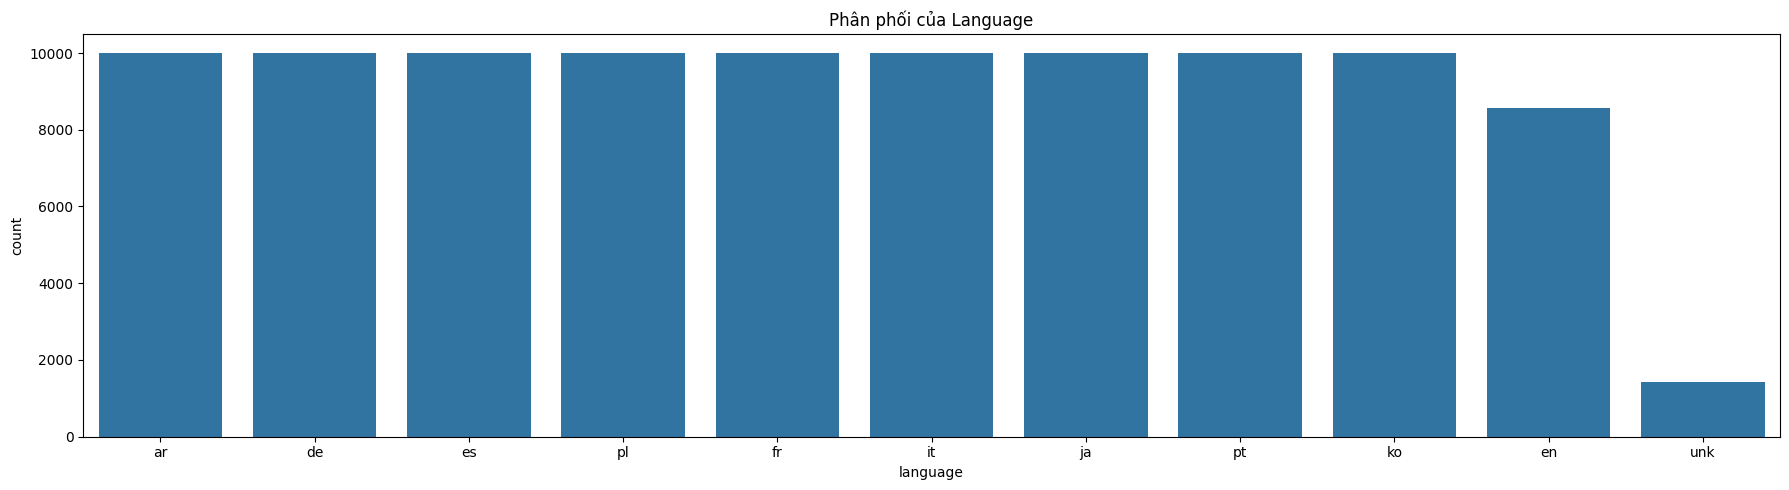

In [26]:
df_dev['language'] = df_dev.apply(lambda x: 'unk' if ( x['language'] == 'en' and x['origin_query'].lower() != x['translated_query'].lower()) else x['language'], axis=1)


# Vẽ biểu đồ phân phối
plt.figure(figsize=(18, 5))
sns.countplot(x='language', data=df_dev, order=df_dev['language'].value_counts().index)
plt.title('Phân phối của Language')


plt.tight_layout()
# plt.savefig('distribution_plots.png')
# print("\nĐã lưu biểu đồ phân phối vào 'distribution_plots.png'")
# print("-" * 30 + "\n")

### 3. Phân tích Dữ liệu Văn bản ###

10 từ phổ biến nhất trong 'translated_query':
[('women', 3312), ('car', 2854), ('bag', 2640), ('men', 2433), ('shoes', 1903), ('woman', 1475), ('clothing', 1345), ('dress', 1345), ('accessories', 1344), ('led', 1151)]

10 từ phổ biến nhất trong 'category_path':
[('accessories', 44750), ('home', 24894), ('parts', 23328), ('garden', 15046), ('clothing', 13923), ('jewelry', 13872), ('automobiles', 11028), ('shoes', 10888), ('bags', 10519), ('women', 10171)]
------------------------------



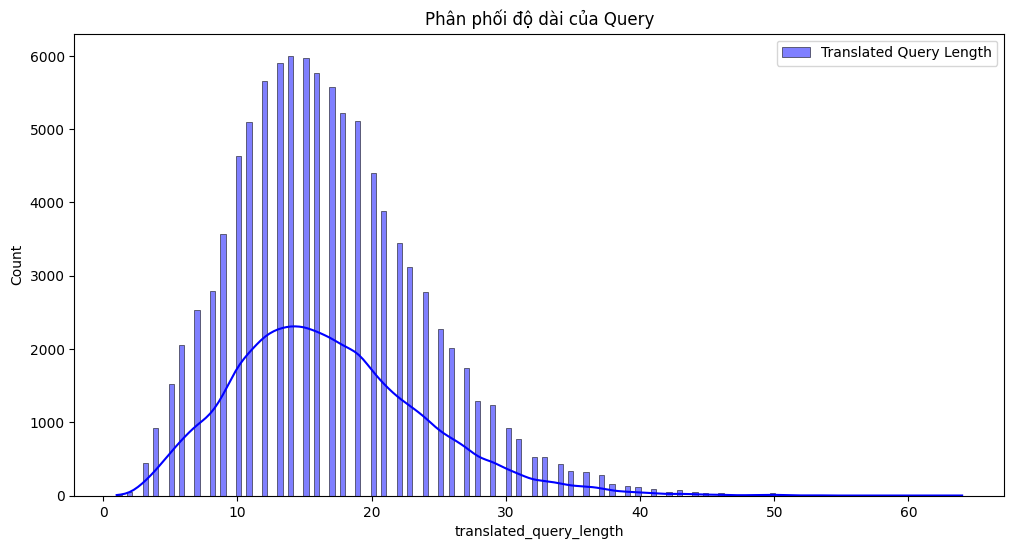

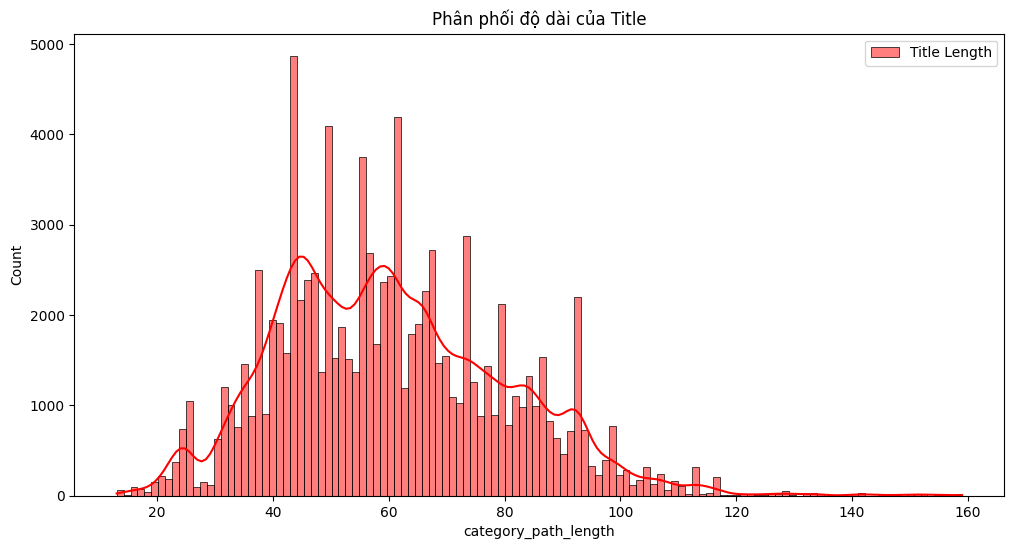

In [27]:
# --- 3. Phân tích Dữ liệu Văn bản ---
print("### 3. Phân tích Dữ liệu Văn bản ###")
# Thêm cột độ dài cho query và title
df_dev['translated_query_length'] = df_dev['translated_query'].str.len()
df_dev['category_path_length'] = df_dev['category_path'].str.len()

# Vẽ biểu đồ phân phối độ dài
plt.figure(figsize=(12, 6))
sns.histplot(df_dev['translated_query_length'], color='blue', label='Translated Query Length', kde=True)
plt.title('Phân phối độ dài của Query')
plt.legend()

plt.figure(figsize=(12, 6))
sns.histplot(df_dev['category_path_length'], color='red', label='Title Length', kde=True)
plt.title('Phân phối độ dài của Title')
plt.legend()
# plt.savefig('text_length_distribution.png')
# print("Đã lưu biểu đồ phân phối độ dài văn bản vào 'text_length_distribution.png'")

# Hàm lấy N từ/cụm từ phổ biến nhất
def get_top_ngrams(corpus, n=None, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Lấy 10 từ phổ biến nhất trong query và title
top_query_words = get_top_ngrams(df_dev['translated_query'], n=10)
top_title_words = get_top_ngrams(df_dev['category_path'], n=10)

print("\n10 từ phổ biến nhất trong 'translated_query':")
print(top_query_words)

print("\n10 từ phổ biến nhất trong 'category_path':")
print(top_title_words)
print("-" * 30 + "\n")

In [28]:
sorted(df_dev['language'].unique().tolist())

['ar', 'de', 'en', 'es', 'fr', 'it', 'ja', 'ko', 'pl', 'pt', 'unk']

In [39]:
k=2 

df_dev['main_category'] = df_dev['category_path'].str.split(',', n=k).str[:k].str.join(', ').str.strip().str.lower()
dev_cats = set(df_dev['main_category'])
len(dev_cats)

384

In [43]:
(dev_cats - train_cats)

{'furniture, senior furniture',
 'luggage & bags, other luggage & bags',
 'office & school supplies, journal'}

## KFold

In [ ]:
# TODO: Handle Unseen Languages ? Eg: Hide some languages on train, show on dev

In [28]:
from pathlib import Path
import pandas as pd 
import numpy as np
import random
from sklearn.model_selection import StratifiedGroupKFold
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

In [29]:
file_path = Path('/home/tnguyenho/workspace/e-commerce-product-search/data/translated/translated_train_QC_full.csv')
out_path = file_path.parent / 'translated_train_QC_full_fold.csv'

In [30]:
df = pd.read_csv(file_path)

In [31]:
k=1

df['main_category'] = df['category_path'].str.split(',', n=k).str[:k].str.join(', ').str.strip().str.lower()
len(set(df['main_category']))

35

In [32]:
df['language'] = df.apply(lambda x: 'unk' if ( x['language'] == 'en' and x['origin_query'].lower() != x['translated_query'].lower()) else x['language'], axis=1)

In [33]:
df['fold'] = -1
df['stratify_col'] = df['language'].astype(str) + '_' + df['main_category'].astype(str) + '_' + df['label'].astype(str)

# Initialize the splitter
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Generate folds

for i, (train_idx, val_idx) in enumerate(sgkf.split(X=df, y=df['stratify_col'], groups=df['origin_query'])):
    df.loc[val_idx, 'fold'] = i

# Verify that a single origin_query only exists in one fold
query_fold_counts = df.groupby('origin_query')['fold'].nunique()
print(f"Number of queries split across multiple folds: {(query_fold_counts > 1).sum()}")
# Expected output: Number of queries split across multiple folds: 0

print(df.fold.value_counts())

/home/tnguyenho/workspace/e-commerce-product-search/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:1035: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Number of queries split across multiple folds: 0
fold
1    60505
0    60276
4    60120
3    59680
2    59419
Name: count, dtype: int64


In [ ]:
def detect_leakage(df: pd.DataFrame, group_col: str, fold_col: str = 'fold'):
    """
    Detects if any group appears in more than one fold, which would indicate
    leakage between training and validation sets.

    Args:
        df (pd.DataFrame): The dataframe containing the data and fold assignments.
        group_col (str): The name of the column to check for leakage (e.g., 'origin_query').
        fold_col (str): The name of the column containing the fold numbers.
    """
    print(f"--- Starting Leakage Detection for column: '{group_col}' ---")
    
    # Get all unique fold numbers, handling cases where folds might not start at 0 or be sequential
    folds = sorted(df[fold_col].unique())
    
    leakage_found = False
    for fold_num in folds:
        print(f"\nChecking Fold {fold_num}...")

        # Define the training and validation sets for the current fold
        train_df = df[df[fold_col] != fold_num]
        val_df = df[df[fold_col] == fold_num]

        # Get the unique group identifiers for each set
        train_groups = set(train_df[group_col].unique())
        val_groups = set(val_df[group_col].unique())

        # Find the intersection, which represents the leaked groups
        intersection = train_groups.intersection(val_groups)

        # some stats here:
        # number labels (train, val)
        # number main_category (train, val)
        # number language (train, val) 

        # print(f"Number of labels in (train, val): {train_df['label'].value_counts()}, {val_df['label'].value_counts()}")  
        print(f"Percentage of labels in (train):\n{train_df['label'].value_counts(normalize=True)}")
        print(f"Percentage of labels in (val):\n{val_df['label'].value_counts(normalize=True)}")
        print(f"Ratio of labels in (val): {val_df['label'].value_counts() / df['label'].value_counts()}")
        print(f"Number of main_category (train, val): {len(train_df['main_category'].unique()), len(val_df['main_category'].unique())}")
        print(f"Number of language (train, val): {len(train_df['language'].unique()), len(val_df['language'].unique())}")
        if not intersection:
            print(f"  ✅ SUCCESS: No leakage found. Validation groups are unique to this fold.")
        else:
            print(f"  ❌ FAILED: Leakage detected! {len(intersection)} groups are in both train and val sets.")
            print(f"     Leaked groups: {intersection}")
            leakage_found = True
            
    print("\n--- Leakage Detection Complete ---")
    if not leakage_found:
        print("Overall Result: No leakage was detected across all folds. Your setup is correct!")
    else:
        print("Overall Result: Leakage was found. Review your folding strategy.")

detect_leakage(df=df, group_col='origin_query')


In [35]:
df.columns

Index(['id', 'task', 'language', 'origin_query', 'category_path', 'label',
       'translated_query', 'main_category', 'fold', 'stratify_col'],
      dtype='object')

In [36]:
df.head()

,id,task,language,origin_query,category_path,label,translated_query,main_category,fold,stratify_col
0,1,QC,unk,baking,"food,grocery,flour, baking and cooking,decorat...",1,baking,food,2,unk_food_1
1,2,QC,unk,baking,"food,grocery,flour, baking and cooking,dry ing...",1,baking,food,2,unk_food_1
2,3,QC,unk,biscuits,"food,grocery,confectionery,cakes, biscuits",1,biscuits,food,0,unk_food_1
3,4,QC,unk,bread,"food,grocery,snacks, chips, crackers,crackers,...",1,bread,food,1,unk_food_1
4,5,QC,unk,caramel,"food,grocery,confectionery,candy, caramel, lol...",1,caramel,food,4,unk_food_1


In [37]:
df.to_csv(out_path, index=False)

In [5]:
import pandas as pd
from typing import List, Iterable

# ==============================================================================
# PHẦN 1: ĐỊNH NGHĨA CẤU TRÚC DỮ LIỆU TRIE (CÂY TIỀN TỐ)
# Bạn có thể đặt phần này trong một file helper riêng nếu muốn.
# ==============================================================================

class TrieNode:
    """Một node trong cây Trie."""
    def __init__(self):
        self.children = {}

class Trie:
    """
    Cấu trúc cây Trie để lưu trữ và tìm kiếm các path hiệu quả.
    """
    def __init__(self, separator=','):
        self.root = TrieNode()
        self.separator = separator

    def insert(self, path_string: str):
        """Chèn một path string (ví dụ: 'a,b,c') vào cây."""
        node = self.root
        parts = path_string.split(self.separator)
        for part in parts:
            # Nếu một phần của path chưa có, tạo node mới
            if part not in node.children:
                node.children[part] = TrieNode()
            # Di chuyển tới node con
            node = node.children[part]

    def find_max_prefix_length(self, path_string: str) -> int:
        """
        Tìm độ dài tiền tố chung lớn nhất của một path_string
        với bất kỳ path nào đã có trong cây.
        """
        node = self.root
        parts = path_string.split(self.separator)
        prefix_len = 0
        for part in parts:
            if part in node.children:
                # Nếu tìm thấy, đi sâu hơn và tăng độ dài
                node = node.children[part]
                prefix_len += 1
            else:
                # Nếu không tìm thấy, dừng lại
                break
        return prefix_len

# ==============================================================================
# PHẦN 2: HÀM TEST CHÍNH
# ==============================================================================

def calculate_max_prefix_overlap(train_paths: Iterable[str], val_paths: Iterable[str]) -> List[int]:
    """
    Với mỗi item trong val_paths, tìm độ dài tiền tố tối đa trùng trong train_paths.

    Args:
        train_paths (Iterable[str]): Một list hoặc Series chứa các category path của tập train.
        val_paths (Iterable[str]): Một list hoặc Series chứa các category path của tập validation.

    Returns:
        List[int]: Một danh sách chứa độ dài tiền tố trùng tối đa, tương ứng với mỗi
                   item trong val_paths.
    """
    # 1. Xây dựng Trie từ tập train để tìm kiếm hiệu quả
    print("Đang xây dựng Trie từ tập train...")
    trie = Trie(separator=',')
    for path in train_paths:
        trie.insert(path)
    print("Xây dựng xong!")

    # 2. Tìm kiếm độ dài tiền tố tối đa cho mỗi path trong tập validation
    overlap_lengths = []
    for path in val_paths:
        length = trie.find_max_prefix_length(path)
        overlap_lengths.append(length)

    return overlap_lengths



In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold

df = pd.read_csv('/home/tnguyenho/workspace/e-commerce-product-search/data/translated/translated_train_QC_full_fold.csv')

# ==============================================================================
# PHẦN CODE ĐÃ SỬA ĐỔI
# ==============================================================================

# Số lượng phần tử trong tiền tố path để nhóm (bạn có thể thay đổi số 3 này)
N_PREFIX = 3

# Bước 1: Tạo cột group mới dựa trên tiền tố của 'category_path'
# Hàm này sẽ lấy N_PREFIX phần đầu của path, ví dụ: 'a,b,c,d' -> 'a,b,c'
def get_path_prefix(path, n):
    parts = path.split(',')
    return ','.join(parts[:n])

df['category_group'] = df['category_path'].apply(lambda x: get_path_prefix(x, N_PREFIX))


# Bước 2: Chuẩn bị cột để phân tầng (giống như code của bạn)
df['fold'] = -1
df['stratify_col'] = df['language'].astype(str) + '_' + df['main_category'].astype(str) + '_' + df['label'].astype(str)


# Bước 3: Thực hiện chia Fold với Group mới
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Chú ý sự thay đổi ở tham số `groups`
for i, (train_idx, val_idx) in enumerate(sgkf.split(X=df, y=df['stratify_col'], groups=df['category_group'])):
    df.loc[val_idx, 'fold'] = i


In [9]:

# ==============================================================================
# PHẦN KIỂM TRA KẾT QUẢ (Tùy chọn)
# ==============================================================================
print("DataFrame với cột 'category_group' và 'fold':")
print(df[['category_path', 'category_group', 'fold']].sort_values('category_group'))
print("\n" + "="*50 + "\n")


# Kiểm tra xem có group nào bị rò rỉ giữa train và test không
for i in range(df['fold'].max() + 1):
    train_groups = set(df[df['fold'] != i]['main_category'])
    val_groups = set(df[df['fold'] == i]['main_category'])

    # Giao của 2 tập hợp phải là rỗng
    leaked_groups = train_groups.intersection(val_groups)

    print(f"Fold {i}:")
    print(f"  - Có {len(val_groups)} groups trong validation:  {list(val_groups)[:3]}")
    if not leaked_groups:
        print(f"  - OK! ✅ Không có group nào bị rò rỉ từ tập train.")
    else:
        print(f"  - Lỗi! ❌ Các group sau bị rò rỉ: {leaked_groups}")
    print("-" * 20)


DataFrame với cột 'category_group' và 'fold':
                                            category_path  \
252643  apparel accessories,apparel fabrics & textiles...   
252646  apparel accessories,apparel fabrics & textiles...   
252676  apparel accessories,apparel fabrics & textiles...   
53343   apparel accessories,apparel fabrics & textiles...   
195345  apparel accessories,apparel fabrics & textiles...   
...                                                   ...   
64397                       women's clothing,women's sets   
296439                      women's clothing,women's sets   
229329                      women's clothing,women's sets   
97887                       women's clothing,women's sets   
264814                      women's clothing,women's sets   

                                           category_group  fold  
252643  apparel accessories,apparel fabrics & textiles...     2  
252646  apparel accessories,apparel fabrics & textiles...     2  
252676  apparel accesso

In [6]:
# Khởi tạo cột mới để lưu kết quả phân tích
df['max_overlap_len'] = -1

# Lấy danh sách các fold đã được chia
all_folds = sorted(df['fold'].unique())

print("Bắt đầu phân tích độ dài tiền tố trùng lặp trên tất cả các fold...")
print("="*60)

# Lặp qua từng fold để thực hiện phân tích
for fold_num in all_folds:
    print(f"\n--- Đang phân tích cho Fold {fold_num} ---")

    # 1. Chia tập train/validation cho fold hiện tại
    train_df = df[df['fold'] != fold_num]
    val_df = df[df['fold'] == fold_num]

    # Nếu tập validation rỗng, bỏ qua (trường hợp n_splits > số lượng group)
    if val_df.empty:
        print(f"Fold {fold_num} không có dữ liệu. Bỏ qua.")
        continue

    # 2. Lấy danh sách các path tương ứng
    train_paths = train_df['category_path']
    val_paths = val_df['category_path']

    # 3. Tính toán độ dài trùng lặp
    overlap_lengths = calculate_max_prefix_overlap(train_paths, val_paths)

    # 4. Lưu kết quả vào DataFrame chính
    # Sử dụng .loc và index của val_df để đảm bảo gán đúng hàng
    df.loc[val_df.index, 'max_overlap_len'] = overlap_lengths

print("\n\n" + "="*60)
print("✅ PHÂN TÍCH HOÀN TẤT")
print("="*60)
print("\nBảng tổng hợp kết quả cuối cùng:")

# In các cột liên quan, sắp xếp theo fold để dễ đọc
print(df[['category_path', 'category_group', 'fold', 'max_overlap_len']].sort_values(by=['fold', 'category_group']))

Bắt đầu phân tích độ dài tiền tố trùng lặp trên tất cả các fold...

--- Đang phân tích cho Fold 0 ---
Đang xây dựng Trie từ tập train...
Xây dựng xong!

--- Đang phân tích cho Fold 1 ---
Đang xây dựng Trie từ tập train...
Xây dựng xong!

--- Đang phân tích cho Fold 2 ---
Đang xây dựng Trie từ tập train...
Xây dựng xong!

--- Đang phân tích cho Fold 3 ---
Đang xây dựng Trie từ tập train...
Xây dựng xong!

--- Đang phân tích cho Fold 4 ---
Đang xây dựng Trie từ tập train...
Xây dựng xong!


✅ PHÂN TÍCH HOÀN TẤT

Bảng tổng hợp kết quả cuối cùng:
                                            category_path  \
94079   apparel accessories,apparel fabrics & textiles...   
179824  apparel accessories,apparel fabrics & textiles...   
179830  apparel accessories,apparel fabrics & textiles...   
180861  apparel accessories,apparel fabrics & textiles...   
183011  apparel accessories,apparel fabrics & textiles...   
...                                                   ...   
298789         women's c

In [7]:
df.to_csv('output.csv', index=False)